In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt

In [2]:
# Select device to accelerate the computation
#check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else device)

print(device)

mps


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("trainset size: ", len(trainset))
print("testset size: ", len(testset))

trainset size:  50000
testset size:  10000


In [4]:
class EncoderNet(nn.Module):
    def __init__(self):
        super().__init__()
        # first layer: 3 input channels, 32 output channels, 3x3 convolutions
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # second layer: 32 input channels, 64 output channels, 3x3 convolutions
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # third layer: 64 input channels, 128 output channels, 3x3 convolutions
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # layer 1 conv + ReLU + pool
        x = self.pool1(torch.relu(self.conv1(x)))
        # layer 2 conv + ReLU + pool
        x = self.pool2(torch.relu(self.conv2(x)))
        # layer 3 conv + ReLU + pool
        x = self.pool3(torch.relu(self.conv3(x)))

        return x


encoder = EncoderNet()
print(encoder)

EncoderNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [5]:
# get one random image from the training set
dataiter = iter(trainloader)
images, labels = next(dataiter)

image = images[0]
image = image.unsqueeze(0)
print(image.shape)

output = encoder(image)
print(output.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 128, 4, 4])


In [6]:
class DecoderNet(nn.Module):
    def __init__(self):
        super(DecoderNet, self).__init__()

        # Define the layers
        self.deconv1 = nn.ConvTranspose2d(
            128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Final convolution to get 3 output channels (RGB image)
        self.final_conv = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Apply each deconvolution (upsampling) layer
        x = torch.relu(self.deconv1(x))  # Upsample to (128, 8, 8)
        x = torch.relu(self.deconv2(x))  # Upsample to (64, 16, 16)
        x = torch.relu(self.deconv3(x))  # Upsample to (32, 32, 32)

        # Apply final convolution and get RGB output
        x = torch.sigmoid(self.final_conv(x))  # Output RGB image (3 channels)

        return x


# Example usage:
# Example latent input with 128 channels and 4x4 spatial size
decoder = DecoderNet()
print(decoder)

DecoderNet(
  (deconv1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (final_conv): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [7]:
# get one random image from the training set
decoder_input = output

decoder_output = decoder(decoder_input)
print(decoder_input.shape)
print(decoder_output.shape)

torch.Size([1, 128, 4, 4])
torch.Size([1, 3, 32, 32])


In [8]:
class ClassifierNet(nn.Module):
    def __init__(self):
        super(ClassifierNet, self).__init__()

        # Define the layers
        self.flatten = nn.Flatten()  # Flatten the input
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # First fully connected layer
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        # Final fully connected layer to output class probabilities
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)  # Flatten the input
        # Apply ReLU activation after the first fully connected layer
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Output layer
        return x


classifier = ClassifierNet()
print(classifier)

ClassifierNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:
classifier_input = output
classifier_output = classifier(classifier_input)
print(classifier_input.shape)
print(classifier_output.shape)

torch.Size([1, 128, 4, 4])
torch.Size([1, 10])


In [10]:
class DualHeadNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = EncoderNet()  # shared encoder

        # decoder
        self.decoder = DecoderNet()

        # classifier
        self.classifier = ClassifierNet()

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        class_logits = self.classifier(latent)
        return reconstruction, class_logits
    
dual_head_net = DualHeadNet()
print(dual_head_net)

DualHeadNet(
  (encoder): EncoderNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): DecoderNet(
    (deconv1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (final_conv): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (

In [11]:
output = dual_head_net(image)
print(output[0].shape)
print(output[1].shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 10])


In [12]:
def cal_total_loss(recon_loss, class_loss, alpha=1.0, beta=1.0):
    return alpha * recon_loss + beta * class_loss


def evaluation(dataloader, model, reconstruction_criterion, classification_criterion, alpha, beta):
    model.eval()
    total_samples = 0
    total_recon_loss = 0.0
    total_class_loss = 0.0
    batch_count = 0
    correct = 0

    with torch.no_grad():
        for data in dataloader:
            # get the inputs; data is a list of [inputs, labels]
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # forward
            recon, logits = model(images)
            recon_loss = reconstruction_criterion(recon, images).item()
            class_loss = classification_criterion(logits, labels).item()

            batch_size = images.size(0)
            total_samples += batch_size
            total_recon_loss += recon_loss * batch_size
            total_class_loss += class_loss * batch_size

            # 准确率统计
            pred = logits.argmax(dim=1)
            correct += pred.eq(labels).sum().item()

    avg_recon = total_recon_loss / total_samples
    avg_class = total_class_loss / total_samples
    total_loss = cal_total_loss(avg_recon, avg_class, alpha, beta)
    acc = 100. * correct / total_samples

    return avg_recon, avg_class, total_loss, acc


def train(model, dataloader, epoch, alpha, beta,  optimizer=None, recon_criterion=None, class_criterion=None):
    model.train()
    total_recon_loss = 0.0
    total_class_loss = 0.0
    batch_count = 0
    correct = 0

    for batch_idx, (images, labels) in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        batch_count += 1
        images = images.to(device)
        labels = labels.to(device)

        # forward
        recon_images, class_logits = model(images)

        # compute loss
        loss_recon = recon_criterion(recon_images, images)
        loss_class = class_criterion(class_logits, labels)
        total_loss = cal_total_loss(loss_recon, loss_class, alpha, beta)

        # backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # collect statistics
        total_recon_loss += loss_recon.item()
        total_class_loss += loss_class.item()
        pred = class_logits.argmax(dim=1)
        correct += pred.eq(labels).sum().item()

    # calculate statistics for the epoch
    avg_recon = total_recon_loss / batch_count
    avg_class = total_class_loss / batch_count
    avg_total_loss = cal_total_loss(avg_recon, avg_class, alpha, beta)
    acc = 100. * correct / batch_count

    return {
        'total_loss': avg_total_loss,
        'recon_loss': avg_recon,
        'class_loss': avg_class,
        'acc': acc
    }

In [13]:
# define the loss function
recon_criterion = nn.MSELoss()         # reconstruction loss
class_criterion = nn.CrossEntropyLoss()  # classification loss

# define important constant training parameters
NUM_EPOCHS = 1000
EARLY_STOPPING = 10

In [14]:
# Alpha is 1.0 and Beta is 1.0
alpha = 1.0
beta = 1.0
filename = 'best_model_a1_b1.pth'

# define the model, optimizer, and scheduler
model = DualHeadNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=25,  # maximum number of epochs
    eta_min=1e-5  # minimum learning rate
)

# train the model
best_val_loss = float('inf')
no_improve_epochs = 0  # number of epochs with no improvement

epoch_pbar = tqdm.tqdm(range(NUM_EPOCHS), desc="Training", unit="epoch")
min_avg_total_loss = 0
epochs = 0

train_losses = []
val_losses = []

for epoch in epoch_pbar:
    all_train_metrics = train(model, trainloader, epoch, alpha, beta,
                              optimizer, recon_criterion, class_criterion)
    train_losses.append(all_train_metrics['total_loss'])

    avg_recon, avg_class, total_loss, acc = evaluation(
        testloader, model, recon_criterion, class_criterion, alpha, beta)
    val_losses.append(total_loss)

    scheduler.step()
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), filename)  # save best model
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= EARLY_STOPPING:
            epoch_pbar.write(f"Early stopping triggered at epoch {epoch+1}")
            early_stop = True
            break

model.load_state_dict(torch.load(filename))
avg_recon, avg_class, total_loss, acc = evaluation(testloader, model, recon_criterion,
                                                   class_criterion, alpha, beta)

print(f'Final => '
      f'Avg Recon Loss: {avg_recon:.4f} | '
      f'Avg Class Loss: {avg_class:.4f} | '
      f'Total loss: {total_loss:.4f} | '
      f'Class Acc: {acc:.2f}%')

Training:   2%|▏         | 20/1000 [12:18<10:02:49, 36.91s/epoch]

Early stopping triggered at epoch 21


Final => Avg Recon Loss: 0.1558 | Avg Class Loss: 0.7133 | Total loss: 0.8691 | Class Acc: 75.62%


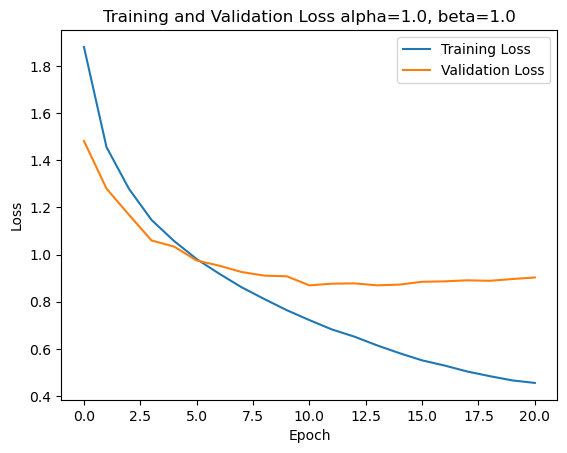

In [15]:
# plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss alpha=1.0, beta=1.0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# Alpha is 10.0 and Beta is 1.0
alpha = 10.0
beta = 1.0
filename = 'best_model_a10_b1.pth'

# define the model, optimizer, and scheduler
model = DualHeadNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,     T_max=50,  # maximum number of epochs
    eta_min=1e-5  # minimum learning rate
)
# train the model
best_val_loss = float('inf')
no_improve_epochs = 0  # number of epochs with no improvement

epoch_pbar = tqdm.tqdm(range(NUM_EPOCHS), desc="Training", unit="epoch")
min_avg_total_loss = 0
epochs = 0

train_losses = []
val_losses = []

for epoch in epoch_pbar:
    all_train_metrics = train(model, trainloader, epoch, alpha, beta,
                              optimizer, recon_criterion, class_criterion)
    train_losses.append(all_train_metrics['total_loss'])

    avg_recon, avg_class, total_loss, acc = evaluation(
        testloader, model, recon_criterion, class_criterion, alpha, beta)
    val_losses.append(total_loss)

    scheduler.step()
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), filename)  # save best model
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= EARLY_STOPPING:
            epoch_pbar.write(f"Early stopping triggered at epoch {epoch+1}")
            early_stop = True
            break

model.load_state_dict(torch.load(filename))
avg_recon, avg_class, total_loss, acc = evaluation(testloader, model, recon_criterion,
                                                   class_criterion, alpha, beta)

print(f'Final => '
      f'Avg Recon Loss: {avg_recon:.4f} | '
      f'Avg Class Loss: {avg_class:.4f} | '
      f'Total loss: {total_loss:.4f} | '
      f'Class Acc: {acc:.2f}%')

Training:   3%|▎         | 26/1000 [15:50<9:53:32, 36.56s/epoch]

Early stopping triggered at epoch 27


Final => Avg Recon Loss: 0.1504 | Avg Class Loss: 0.7158 | Total loss: 2.2194 | Class Acc: 75.60%


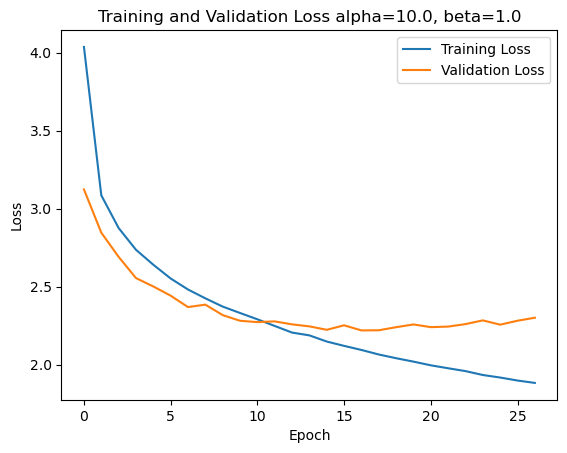

In [17]:
# plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss alpha=10.0, beta=1.0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Alpha is 10.0 and Beta is 10.0
alpha = 10.0
beta = 10.0
filename = 'best_model_a10_b10.pth'

# define the model, optimizer, and scheduler
model = DualHeadNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,     T_max=50,  # maximum number of epochs
    eta_min=1e-5  # minimum learning rate
)

# train the model
best_val_loss = float('inf')
no_improve_epochs = 0  # number of epochs with no improvement

epoch_pbar = tqdm.tqdm(range(NUM_EPOCHS), desc="Training", unit="epoch")
min_avg_total_loss = 0
epochs = 0

train_losses = []
val_losses = []

for epoch in epoch_pbar:
    all_train_metrics = train(model, trainloader, epoch, alpha, beta,
                              optimizer, recon_criterion, class_criterion)
    train_losses.append(all_train_metrics['total_loss'])

    avg_recon, avg_class, total_loss, acc = evaluation(
        testloader, model, recon_criterion, class_criterion, alpha, beta)
    val_losses.append(total_loss)

    scheduler.step()
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), filename)  # save best model
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= EARLY_STOPPING:
            epoch_pbar.write(f"Early stopping triggered at epoch {epoch+1}")
            early_stop = True
            break

model.load_state_dict(torch.load(filename))
avg_recon, avg_class, total_loss, acc = evaluation(testloader, model, recon_criterion,
                                                   class_criterion, alpha, beta)

print(f'Final => '
      f'Avg Recon Loss: {avg_recon:.4f} | '
      f'Avg Class Loss: {avg_class:.4f} | '
      f'Total loss: {total_loss:.4f} | '
      f'Class Acc: {acc:.2f}%')

Training:   2%|▏         | 22/1000 [13:36<10:04:49, 37.11s/epoch]

Early stopping triggered at epoch 23


Final => Avg Recon Loss: 0.1565 | Avg Class Loss: 0.7217 | Total loss: 8.7819 | Class Acc: 75.59%


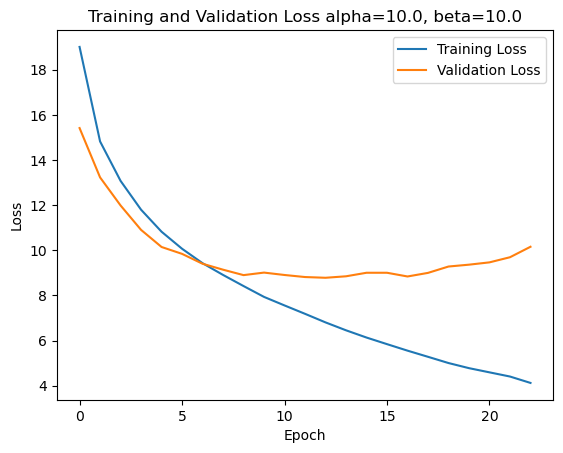

In [19]:
# plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss alpha=10.0, beta=10.0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Alpha is 5.0 and Beta is 5.0
alpha = 5.0
beta = 5.0
filename = 'best_model_a5_b5.pth'

# define the model, optimizer, and scheduler
model = DualHeadNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,     T_max=50,  # maximum number of epochs
    eta_min=1e-5  # minimum learning rate
)

# train the model
best_val_loss = float('inf')
no_improve_epochs = 0  # number of epochs with no improvement

epoch_pbar = tqdm.tqdm(range(NUM_EPOCHS), desc="Training", unit="epoch")
min_avg_total_loss = 0
epochs = 0

train_losses = []
val_losses = []

for epoch in epoch_pbar:
    all_train_metrics = train(model, trainloader, epoch, alpha, beta,
                              optimizer, recon_criterion, class_criterion)
    train_losses.append(all_train_metrics['total_loss'])

    avg_recon, avg_class, total_loss, acc = evaluation(
        testloader, model, recon_criterion, class_criterion, alpha, beta)
    val_losses.append(total_loss)

    scheduler.step()
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), filename)  # save best model
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= EARLY_STOPPING:
            epoch_pbar.write(f"Early stopping triggered at epoch {epoch+1}")
            early_stop = True
            break

model.load_state_dict(torch.load(filename))
avg_recon, avg_class, total_loss, acc = evaluation(testloader, model, recon_criterion,
                                                   class_criterion, alpha, beta)

print(f'Final => '
      f'Avg Recon Loss: {avg_recon:.4f} | '
      f'Avg Class Loss: {avg_class:.4f} | '
      f'Total loss: {total_loss:.4f} | '
      f'Class Acc: {acc:.2f}%')

Training:   2%|▏         | 17/1000 [10:00<9:36:05, 35.16s/epoch]

In [ ]:
# plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss alpha=5.0, beta=5.0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Alpha is 0.1 and Beta is 1.0
alpha = 0.1
beta = 1.0
filename = 'best_model_a0.1_b1.0.pth'

# define the model, optimizer, and scheduler
model = DualHeadNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,     T_max=50,  # maximum number of epochs
    eta_min=1e-5  # minimum learning rate
)

# train the model
best_val_loss = float('inf')
no_improve_epochs = 0  # number of epochs with no improvement

epoch_pbar = tqdm.tqdm(range(NUM_EPOCHS), desc="Training", unit="epoch")
min_avg_total_loss = 0
epochs = 0

train_losses = []
val_losses = []

for epoch in epoch_pbar:
    all_train_metrics = train(model, trainloader, epoch, alpha, beta,
                              optimizer, recon_criterion, class_criterion)
    train_losses.append(all_train_metrics['total_loss'])

    avg_recon, avg_class, total_loss, acc = evaluation(
        testloader, model, recon_criterion, class_criterion, alpha, beta)
    val_losses.append(total_loss)

    scheduler.step()
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), filename)  # save best model
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= EARLY_STOPPING:
            epoch_pbar.write(f"Early stopping triggered at epoch {epoch+1}")
            early_stop = True
            break

model.load_state_dict(torch.load(filename))
avg_recon, avg_class, total_loss, acc = evaluation(testloader, model, recon_criterion,
                                                   class_criterion, alpha, beta)

print(f'Final => '
      f'Avg Recon Loss: {avg_recon:.4f} | '
      f'Avg Class Loss: {avg_class:.4f} | '
      f'Total loss: {total_loss:.4f} | '
      f'Class Acc: {acc:.2f}%')

In [ ]:
# plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss alpha=0.1, beta=1.0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Alpha is 1.0 and Beta is 0.1
alpha = 0.1
beta = 1.0
filename = 'best_model_a1.0_b0.1.pth'

# define the model, optimizer, and scheduler
model = DualHeadNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,     T_max=50,  # maximum number of epochs
    eta_min=1e-5  # minimum learning rate
)

# train the model
best_val_loss = float('inf')
no_improve_epochs = 0  # number of epochs with no improvement

epoch_pbar = tqdm.tqdm(range(NUM_EPOCHS), desc="Training", unit="epoch")
min_avg_total_loss = 0
epochs = 0

train_losses = []
val_losses = []

for epoch in epoch_pbar:
    all_train_metrics = train(model, trainloader, epoch, alpha, beta,
                              optimizer, recon_criterion, class_criterion)
    train_losses.append(all_train_metrics['total_loss'])

    avg_recon, avg_class, total_loss, acc = evaluation(
        testloader, model, recon_criterion, class_criterion, alpha, beta)
    val_losses.append(total_loss)

    scheduler.step()
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), filename)  # save best model
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= EARLY_STOPPING:
            epoch_pbar.write(f"Early stopping triggered at epoch {epoch+1}")
            early_stop = True
            break

model.load_state_dict(torch.load(filename))
avg_recon, avg_class, total_loss, acc = evaluation(testloader, model, recon_criterion,
                                                   class_criterion, alpha, beta)

print(f'Final => '
      f'Avg Recon Loss: {avg_recon:.4f} | '
      f'Avg Class Loss: {avg_class:.4f} | '
      f'Total loss: {total_loss:.4f} | '
      f'Class Acc: {acc:.2f}%')

In [ ]:
# plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss alpha=1.0, beta=0.1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()